Neural network learning
===
notebook written by Patrick van der Smagt

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
%matplotlib inline

We start off with defining transfer functions.  These are the (nonlinear) functions $\phi$ in the neurons.

The implementation is a bit weird: it returns $y = \phi(x, \mathrm{False})$ or $s = \phi(y, \mathrm{True})$ where $y = \phi(x)$.  So if the second parameter is True, the first argument is interpreted to be $\phi(x)$ and is used to compute the derivative.  This is done for computational efficiency only.

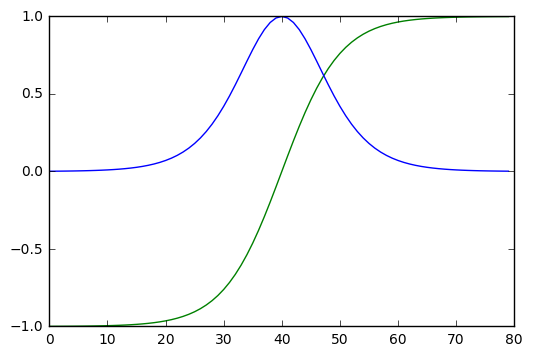

In [63]:
# sigmoid function.  returns y=sigmoid(x) or y' = sigmoid(y, True)
def sigmoid(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))
# tanh function.
def tanh(x,deriv=False):
    if(deriv==True):
        return 1-x*x
    return np.tanh(x)
# tanh function.
def linear(x,deriv=False):
    if(deriv==True):
        return 1
    return x
def rectifier(x, deriv=False):
    if (deriv==True):
        return (x > 0.)
    return x * (x > 0.)

actfunc = tanh              # transfer function
x=np.arange(-4,4,.1)
y = actfunc(x)
plt.plot(y, "green");
s = actfunc(y,True)      # derivative

#Tracer()()
plt.plot(s, "blue");

Let's start off with a simple neural network with no hidden layer
---
This simple "neural network"---in this form also known as perceptron---does a simple forward pass, then computes the output errors, and uses those to adapt the weights.

Note that this thing does something like linear regression---and the error is a convex function in its parameters w.

w0 shape (3, 1) print w0 [[ 0.]
 [ 0.]
 [ 0.]]
perceptron output:
[[  1.27116281e-04]
 [  1.26987403e-04]
 [  2.75971559e+00]
 [  2.75971546e+00]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[  1.27129125e-04]
 [  1.27000221e-04]
 [  9.92015344e-01]
 [  9.92015342e-01]]


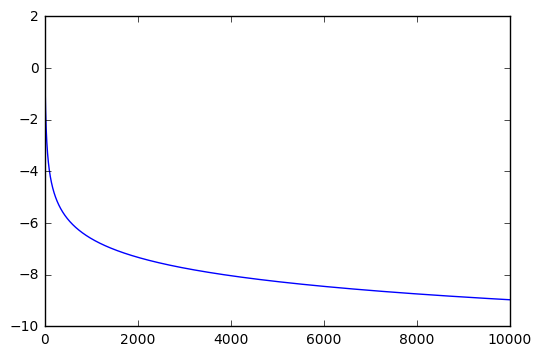

In [141]:
# input dataset.  Why is the third input always 1?
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
z = np.array([[0,0,1,1]]).T

# seed random numbers
np.random.seed()

# initialize weights randomly with mean 0
# What happens if I start with w0 = 0?
w0 = 2*np.random.random((X.shape[1],1)) - 1
w0 = np.zeros((X.shape[1],1))
print("w0 shape", w0.shape, "print w0", w0)
loss = []

# the transfer function
transfer = tanh

# the learning rate
learn_rate = 0.1

# make so many steps
for iter in range(10000):
    # forward propagation: layer 0 is the input
    l0 = X
    # layer one is dot product of l0 with w0, 
    # then the transfer function.  l1 is the output, i.e., y
    l1 = transfer(np.dot(l0,w0))

    # What is the residual?  Note that the error
    # equals the absolute residual.
    residual = z - l1
    # In the MLE interpretation we assume Gaussian errors in
    # the data.  So the loss is the sum of squared errors:
    loss.append(sum(i**2 for i in residual))

    # To find the residual at the inputs of the output unit, we
    # "propagate it through the unit", i.e., we multiply the
    # residual with the derivative of the transfer function.
    # We call the result "delta".  You can easily show that
    # this is mathematically correct.
    l1_delta = residual * transfer(l1,True)
    #l1_delta = residual

    # Update weights.  How can this be extended with a momentum term?
    w0 += learn_rate * np.dot(l0.T,l1_delta)

print ("perceptron output:")
print (np.dot(l0,w0))
print(l0[:,0:2])
print (l1)
plt.plot(np.log(loss));

Neural Network Implementation
----
A neural network with one hidden layer.  Biases are not added by this implementation (why is that no problem?).  Also, momentum is not implemented yet---please implement that to get faster learning, as soon as you know what is meant by "momentum".

In [288]:
class MyMLP:
    def __init__(self, n_inpt, n_hidden, n_output, hid_transfer = tanh, out_transfer = tanh):
        self.w0 = 2*np.random.random((n_inpt, n_hidden))
        self.w1 = 2*np.random.random((n_hidden, n_output))
        print("initial w0", self.w0)
        print("initial w1", self.w1.T)
        self.hid_transfer = hid_transfer
        self.out_transfer = out_transfer
        self.loss = []
    
    def ffnn_forward(self, X):
        l0 = X
        l1 = self.hid_transfer(np.dot(l0,self.w0))
        #print("l0 shape",l0.shape)
        #print("w0 shape",self.w0.shape)
        l2 = self.out_transfer(np.dot(l1,self.w1))
        return (l0,l1,l2)

    def NeuralNetwork(self, X, z, learn_rate = 0.1, momentum = 0.9,iterations=6000):
        # search direction for the weights in layers 1 and 0
        optim_step1 = 0
        optim_step0 = 0

        prev_full_grad1 = np.zeros(self.w1.shape)
        prev_full_grad0 = np.zeros(self.w0.shape)
        
        w1_final = self.w1
        w0_final = self.w0
        for j in range(iterations):

            # Feed forward through layers 0, 1, and 2
            # l0 is the input layer
            # l1 is the hidden layer
            # l2 is the output layer
            (l0,l1,l2) = self.ffnn_forward(X)

            # (signed) error at the output
            residual = z - l2
            # the loss is the sum of squared errors
            self.loss.append(sum(i**2 for i in residual))

            # compute the delta.
            l2_delta = residual*self.out_transfer(l2,deriv=True)

            # back-propagate the output delta to the hidden units
            l1_error = l2_delta.dot(self.w1.T)

            # compute the delta at the hidden units
            l1_delta = l1_error * self.hid_transfer(l1,deriv=True)
            
            #compute current gradient
            cur_full_grad1 = l1.T.dot(l2_delta) + momentum*prev_full_grad1
            cur_full_grad0 = l0.T.dot(l1_delta) + momentum*prev_full_grad0
            
            prev_full_grad1 = cur_full_grad1
            prev_full_grad0 = cur_full_grad0

            #batch learning
            #optim_step1 = learn_rate*l1.T.dot(l2_delta)
            #optim_step0 = learn_rate*l0.T.dot(l1_delta)
            
            #batch learning with momentum
            optim_step1 = learn_rate*cur_full_grad1
            optim_step0 = learn_rate*cur_full_grad0

            self.w1 += optim_step1
            self.w0 += optim_step0

        plt.figure()
        plt.plot(self.loss);
        #print("Neha")
        print("final_Wo", self.w0, " shape ",self.w0.shape)
        print("final_w1", self.w1.T, " shape ",self.w1.shape)
        
        #plt.figure()
        #plt.plot(X[:,0],X[:,1],"go")
        #plt.plot(X[1:3,0],X[1:3,1],"ro")
        
        #plt.plot(X[0,0],X[0,1],"go")
        #plt.plot(X[1,0],X[1,1],"ro")
        #plt.plot(X[2,0],X[2,1],"ro")
        #plt.plot(X[3,0],X[3,1],"go")
        
        
        #plt.plot(l1[0,0],l1[0,1],"gs")
        #plt.plot(l1[1,0],l1[1,1],"rs")
        #plt.plot(l1[2,0],l1[2,1],"rs")
        #plt.plot(l1[3,0],l1[3,1],"gs")
        
        #x = np.arange(-0.1, 1.1, 0.1);
        #y = (-self.w0[0,0]*x - self.w0[2,0])/(self.w0[1,0])
        #plt.plot(x, y, color = "blue")
        
        
        #x = np.arange(-0.1, 1.1, 0.1);
        #y = (-self.w0[0,1]*x - self.w0[2,1])/(self.w0[1,1])
        #plt.plot(x, y, color = "orange")
        #plt.axis([-5,5,-5,5])
        #print("L2_deltashape", l2_delta.shape)

Print the contour plot of this NN with a two-dimensional input

In [289]:
def nncontour (start, end, step, mlp):
    xx, yy = np.meshgrid( np.arange(start, end, step),  np.arange(start, end, step))
    x = np.array([[0,0,1]])
    z = np.zeros(( len(xx[:,0]), len(yy[:,0])) )
    for i in range(len(xx[:,0])):
        for j in range(len(yy[:,0])):
            x = [[xx[i,j], yy[i,j], 1]]
            (l0,l1,l2) = mlp.ffnn_forward(x)
            z[i, j] = l2.item(0)
    plt.figure()
    plt.contour(xx, yy, z)
    print(xx)

Now do a typical silly example: the XOR function.  Please play around with the parameters of the NN: number of hiddens, the learning rate, the momentum...

initial w0 [[ 0.58865297  1.30888347]
 [ 1.50796117  1.83643397]
 [ 0.07688594  0.19464688]]
initial w1 [[ 0.63046753  1.74096765]]
final_Wo [[ 1.22628168  3.65364855]
 [ 1.22887675  3.68196282]
 [-1.15896311 -1.86723512]]  shape  (3, 2)
final_w1 [[-3.97900809  3.42522983]]  shape  (2, 1)
output
[[-0.82070168 -0.9533428 ]
 [ 0.06979995  0.94831011]
 [ 0.06721706  0.94538076]
 [ 0.86074049  0.99996442]]
[[  1.60414111e-04   9.94754423e-01   9.94756972e-01   2.14574478e-04]]


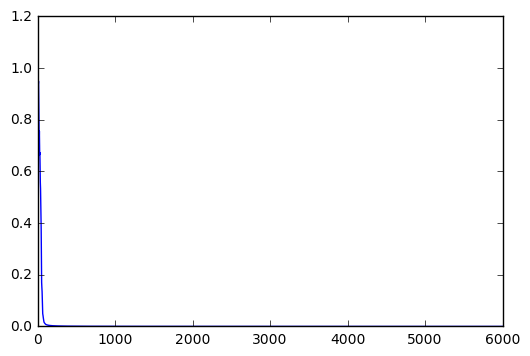

In [329]:
X = np.array([[0,0,1],
            [0,1,1],
            [1,0,1],
            [1,1,1]])
                
y = np.array([[0],
			[1],
			[1],
			[0]])

mlp_xor = MyMLP(X.shape[1], 2, y.shape[1])
mlp_xor.NeuralNetwork(X,y,0.1,0.9)
(l0, l1, l2) = mlp_xor.ffnn_forward(X)
print("output")
print(l1)
print(l2.T)


#nncontour(0,1.1, 0.01, mlp_xor)

Draw Hinton diagrams
---
Hinton diagrams can be used to represent weights in a NN.  Each box represents a single weight.  The colour of the box indicates the sign of the weight (black: negative; white: positive); the size of the box the size of the weight.

In [292]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        #max_weight = 0.5 * 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))
        max_weight = np.max(np.abs(matrix))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w)) / max_weight
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


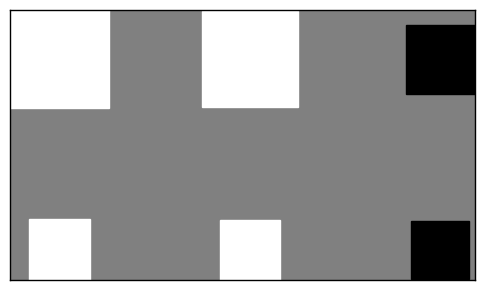

In [293]:
hinton(mlp_xor.w0)

Now try to fit a sine wave.  Experiment with, e.g., very many and very few hidden units.  Try it with and without momentum in the learning.

In [343]:
data = np.arange(-3,3,0.05) # is it enough data??
X = np.array([[x, 1] for x in data])
y = np.array([[np.sin(x)+np.random.randn()/100 for x in data]]).T
mlp_sin = MyMLP(X.shape[1],10,y.shape[1], hid_transfer=sigmoid)
print(X.shape)
print(y.shape)

initial w0 [[ 1.23240008  0.46548029  0.19138907  0.07422596  1.98490918  0.6253711
   1.63902671  1.57693451  1.35916468  1.45801029]
 [ 0.47056194  1.54501561  1.11995933  1.5283099   0.63281661  1.81512609
   0.97814098  0.12031163  1.9629395   0.64106987]]
initial w1 [[ 1.94755587  1.24353918  0.91833295  0.02571169  0.60019351  0.67287472
   0.60095168  0.39636531  0.37014438  0.86926357]]
(120, 2)
(120, 1)


final_Wo [[-0.2034483   1.34849968  3.2814744  -2.66443516 -0.17194973 -4.19626604
   3.24112112 -0.17655184 -0.19700262 -0.17694539]
 [-4.76702401 -3.43768665 -6.78802115 -2.27629094 -3.68945436 -9.33254691
  -3.17787976 -3.71966503 -4.82573645 -3.98355185]]  shape  (2, 10)
final_w1 [[ 2.1994579  -0.18171999 -2.48975376 -2.37935138  1.31469654  2.11536752
   2.51808453  1.31175044  3.27255039  1.68762801]]  shape  (10, 1)


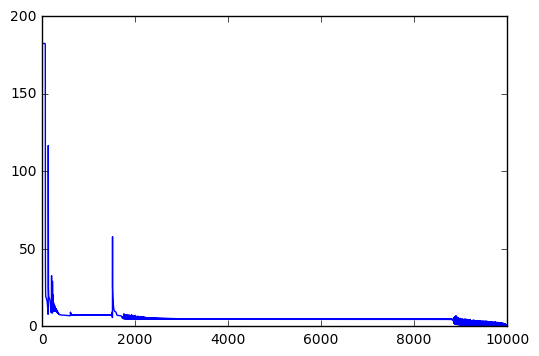

In [344]:
mlp_sin.NeuralNetwork(X,y,0.1,0.0,10000)


# Plot the output of the neural network over the training data.

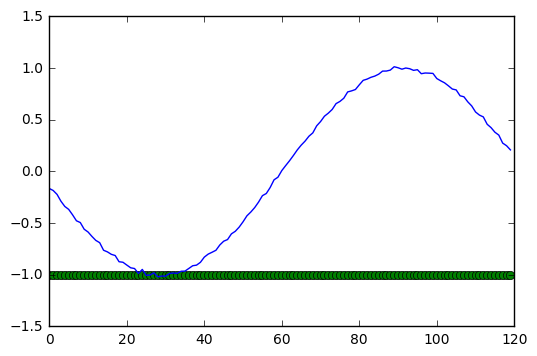

In [339]:
(l0,l1,l2) = mlp_sin.ffnn_forward(X)
plt.plot(l2, "go")
plt.plot(y, "blue")